In [1]:
import functools
from typing import Literal, Optional, Iterable

import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import scanpy as sc
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm, genot
from ott.neural.networks.layers import time_encoder
from ot_pert.nets.nets import CondVelocityField
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import joypy
import pandas as pd
import pickle

In [130]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

def project_data(data: np.ndarray, projection_matrix: np.ndarray, mean_to_subtract: np.ndarray) -> np.ndarray:
    return np.matmul(data - mean_to_subtract, projection_matrix)

In [3]:
obsm_key_cond = "ecfp_cell_line_logdose_more_dose"
obsm_key_data = "X_pca"

In [4]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_biolord_split_30.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_biolord_split_30.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_biolord_split_30.h5ad"

In [5]:
adata_train = sc.read(adata_train_path)
adata_ood = sc.read(adata_ood_path)
adata_test = sc.read(adata_test_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
adata_train.obsm["ecfp_cell_line_logdose_more_dose"].shape

(309540, 1424)

In [7]:
source_dim=30
target_dim=30
condition_dim=1424

In [8]:
vf = CondVelocityField(
    hidden_dims=[512, 512, 512],
    time_dims=[512, 512, 512],
    output_dims=[1024, 1024, 1024] + [target_dim],
    condition_dims=[4096, 4096, 4096],
    dropout_rate=0.0,
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
)

model = genot.GENOT(
    vf,
    flow=dynamics.ConstantNoiseFlow(0),
    data_match_fn=None,
    source_dim=source_dim,
    target_dim=target_dim,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(1e-4), 2),
)




2024-05-28 08:31:38.395788: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [30]:
load_path = f"/lustre/groups/ml01/workspace/ot_perturbation/models/genot/sciplex/earthy-sunset-102_model.pkl"

# Open the file containing the saved parameters
with open(load_path, 'rb') as f:
    loaded_params = pickle.load(f)

check_load = jax.tree_util.tree_map(lambda x,y: x.shape==y.shape, model.vf_state.params, loaded_params)
def all_values_true(d):
    if isinstance(d, dict):
        return all(all_values_true(v) for v in d.values())
    return d is True
all_values_true(check_load)

True

In [31]:
from flax.core.frozen_dict import FrozenDict
new_params = FrozenDict(loaded_params)

if hasattr(model.vf_state, 'replace'):
    model.vf_state = model.vf_state.replace(params=new_params)
else:
    raise ValueError

In [32]:
OBSM_KEY_DATA = "X_pca"
OBSM_KEY_COND = "ecfp_cell_line_logdose_more_dose"

In [33]:
def load_data(adata, obsm_key_data, obsm_key_cond):
    """Loads data and preprocesses it based on configuration."""
    dls = []
    data_source = {}
    data_target = {}
    data_source_decoded = {}
    data_target_decoded = {}
    data_conditions = {}
    for cond in adata.obs["condition"].cat.categories:
        if "Vehicle" not in cond:
            src_str_unique = list(adata[adata.obs["condition"] == cond].obs["cell_type"].unique())
            assert len(src_str_unique) == 1
            src_str = src_str_unique[0] + "_Vehicle_0.0"
            source = adata[adata.obs["condition"] == src_str].obsm[obsm_key_data]
            source_decoded = adata[adata.obs["condition"] == src_str].X.A
            target = adata[adata.obs["condition"] == cond].obsm[obsm_key_data]
            target_decoded = adata[adata.obs["condition"] == cond].X.A
            conds = adata[adata.obs["condition"] == cond].obsm[obsm_key_cond]
            assert np.all(np.all(conds == conds[0], axis=1))
            conds = np.tile(conds[0], (len(source), 1))
            data_source[cond] = source
            data_target[cond] = target
            data_source_decoded[cond] = source_decoded
            data_target_decoded[cond] = target_decoded
            data_conditions[cond] = conds
    return {
        "source": data_source,
        "target": data_target,
        "source_decoded": data_source_decoded,
        "target_decoded": data_target_decoded,
        "conditions": data_conditions,
    }


In [34]:
test_data_dict = load_data(adata_test, OBSM_KEY_DATA, OBSM_KEY_COND)

In [131]:
reconstruct_data_fn = functools.partial(
        reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
    )

project_data_fn = functools.partial(project_data, projection_matrix = adata_train.varm["PCs"], mean_to_subtract=adata_train.varm["X_train_mean"].T)

In [41]:
def interpolate_continuous_covariate(model, source: jnp.ndarray, condition_without_covariate: jnp.ndarray, covariate_values: Iterable):
    assert condition_without_covariate.shape[0] == 1 # we only do one condition
    conditions = {}
    for cov in covariate_values:
        conds = np.concatenate((condition_without_covariate, jnp.array([[cov] * 100])), axis=-1)
        conditions[cov] = np.tile(conds, (len(source), 1))
    return jtu.tree_map(lambda c: functools.partial(model.transport, source=source)(condition=c), conditions)

In [88]:
[el for el in test_data_dict["conditions"].keys() if "inostat" in el]



['A549_Droxinostat_10.0',
 'A549_Droxinostat_100.0',
 'A549_Droxinostat_1000.0',
 'A549_Droxinostat_10000.0',
 'A549_Entinostat_(MS-275)_10.0',
 'A549_Entinostat_(MS-275)_100.0',
 'A549_Entinostat_(MS-275)_1000.0',
 'A549_Resminostat_10.0',
 'A549_Resminostat_100.0',
 'K562_Droxinostat_1000.0',
 'K562_Entinostat_(MS-275)_10.0',
 'K562_Entinostat_(MS-275)_100.0',
 'K562_Entinostat_(MS-275)_1000.0',
 'K562_Pracinostat_(SB939)_10.0',
 'K562_Resminostat_10.0',
 'K562_Tucidinostat_(Chidamide)_10.0',
 'MCF7_Abexinostat_(PCI-24781)_10.0',
 'MCF7_Abexinostat_(PCI-24781)_100.0',
 'MCF7_Abexinostat_(PCI-24781)_1000.0',
 'MCF7_Abexinostat_(PCI-24781)_10000.0',
 'MCF7_Droxinostat_10.0',
 'MCF7_Droxinostat_100.0',
 'MCF7_Droxinostat_1000.0',
 'MCF7_Droxinostat_10000.0',
 'MCF7_Entinostat_(MS-275)_10.0',
 'MCF7_Entinostat_(MS-275)_100.0',
 'MCF7_Entinostat_(MS-275)_1000.0',
 'MCF7_Entinostat_(MS-275)_10000.0',
 'MCF7_Mocetinostat_(MGCD0103)_1000.0',
 'MCF7_Mocetinostat_(MGCD0103)_10000.0',
 'MCF7_Pa

In [38]:
adata = adata_test

In [89]:
perturbation_condition = "MCF7_Entinostat_(MS-275)_10000.0"
src_str_unique = list(adata[adata.obs["condition"] == perturbation_condition].obs["cell_type"].unique())
assert len(src_str_unique) == 1
src_str = src_str_unique[0] + "_Vehicle_0.0"
source = adata[adata.obs["condition"] == src_str].obsm[OBSM_KEY_DATA]
conds = adata[adata.obs["condition"] == perturbation_condition].obsm[OBSM_KEY_COND]
condition_without_covariate = conds[0,...,:-100][None,...]
covariate_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]



In [90]:
interpolation_results = interpolate_continuous_covariate(model, source, condition_without_covariate, covariate_values)


In [91]:
prediction_decoded = jtu.tree_map(reconstruct_data_fn, interpolation_results)

In [92]:
dfs = []
for k, preds in prediction_decoded.items():
    df = pd.DataFrame(data=preds, columns=adata_train.var_names)
    df["dosage"] = k
    df["mode"] = "predicted"
    dfs.append(df)

In [93]:
df_preds = pd.concat(dfs)

In [94]:
gene1 = "ACSS2"

In [134]:
pert_condition_without_dose = "MCF7_Entinostat_(MS-275)_"
dfs_ground_truth = []
for dose in adata.obs["dose"].unique():
    if dose == 0.0:
        continue
    pert_condition = pert_condition_without_dose + str(dose)
    cols = pd.Index([gene+"_true" for gene in adata_train.var_names])
    data = adata_train[adata_train.obs["condition"]==pert_condition].X.A
    data = reconstruct_data_fn(project_data_fn(data))
    df = pd.DataFrame(data=data, columns=cols)
    df["dosage"] = np.log10(dose)
    df["mode"] = "true"
    dfs_ground_truth.append(df)
    

In [96]:
df_preds.index = df_preds.index.map(lambda x: f"{x}-2")

In [97]:
df_preds.index = np.arange(len(df_preds))

In [135]:
df_ground_truth = pd.concat(dfs_ground_truth)

In [136]:
df_ground_truth.index = np.arange(len(df_ground_truth)) + 10000

In [137]:
df = pd.concat((df_ground_truth, df_preds), axis=1)

In [138]:
df = df_ground_truth

In [139]:
df_preds.dosage.unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. ])

In [103]:
from ot_pert.plotting import joyplot

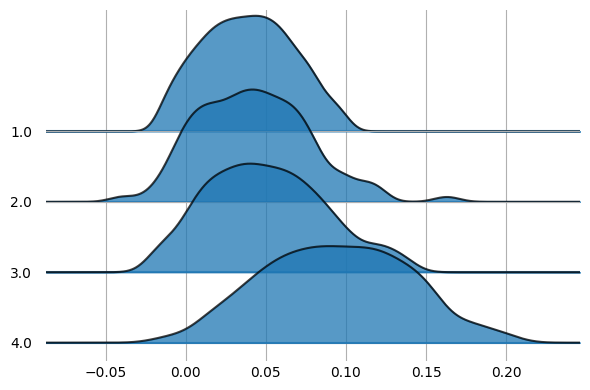

In [140]:
fig, axes = joyplot(
    df_ground_truth[[gene1+"_true", "dosage"]],
    by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)

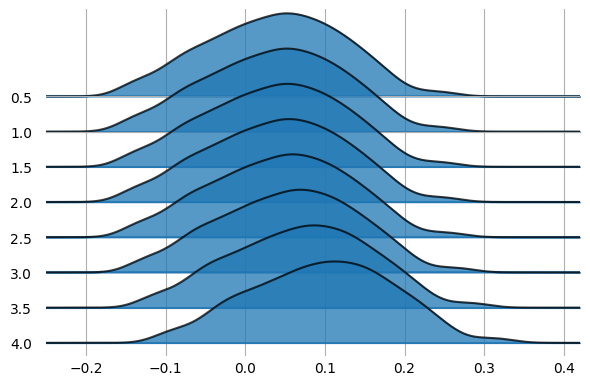

In [105]:
fig, axes = joyplot(
    df_preds[[gene1, "dosage"]],
    by='dosage',
    alpha=0.75,
    figsize=(6, 4),
    grid='both',
    kind="kde",
)


In [106]:
counts_pred = np.concatenate(list(prediction_decoded.values()))

In [107]:
import anndata
obs_arr=[]
for dose in prediction_decoded.keys():
    obs_arr.append([dose] * 500)

In [108]:
adata_pred = anndata.AnnData(counts_pred)

In [109]:
adata_pred.obs["dose"] = np.concatenate(obs_arr)

In [110]:
sc.pp.neighbors(adata_pred)
sc.tl.umap(adata_pred)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [111]:
adata_pred.obs["dose_cat"] = adata_pred.obs["dose"].astype("category")

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


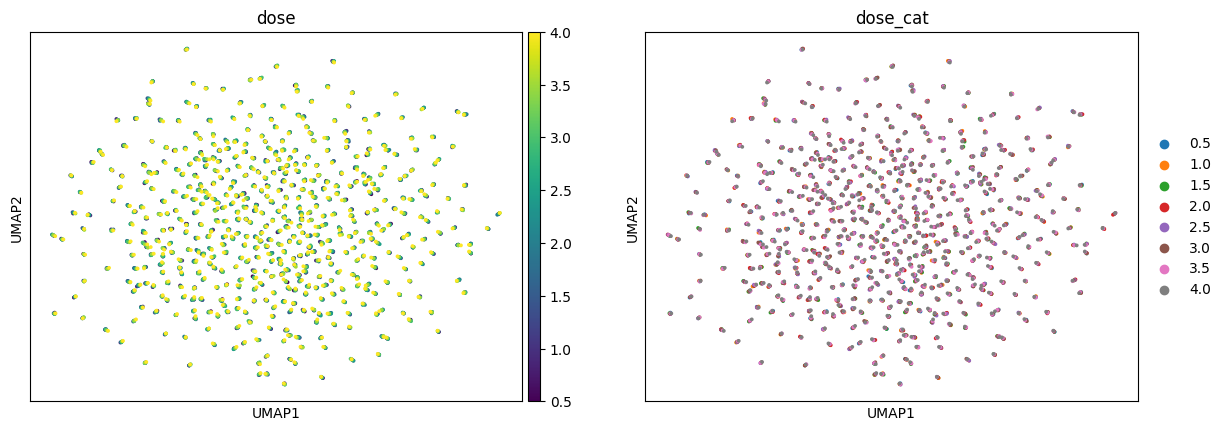

In [112]:
sc.pl.umap(adata_pred, color=["dose", "dose_cat"])

In [113]:
adata_true = adata["MCF7_Entinostat_(MS-275)" in adata.obs["condition"]]

In [114]:
adata_tmp = adata[(adata.obs["drug"]=="Entinostat_(MS-275)") & (adata.obs["cell_type"]=="MCF7")]

In [115]:
adata_pred.var_names = adata_tmp.var_names

In [116]:
adata_tmp.obs["dose"] = adata_tmp.obs.apply(lambda x: np.log10(x["dose"]), axis=1)

/tmp/ipykernel_76172/592764376.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_tmp.obs["dose"] = adata_tmp.obs.apply(lambda x: np.log10(x["dose"]), axis=1)


In [117]:
adata_tmp.obs["mode"] = "True"
adata_pred.obs["mode"] = "pred"

In [118]:
adata_joint = anndata.concat((adata_tmp, adata_pred))


In [119]:
sc.pp.pca(adata_joint)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)


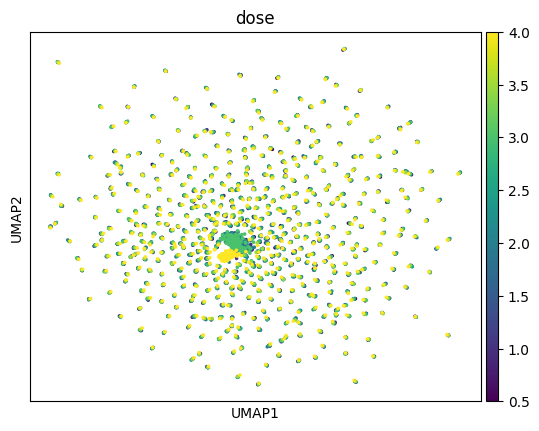

In [120]:
sc.pl.umap(adata_joint, color="dose")

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


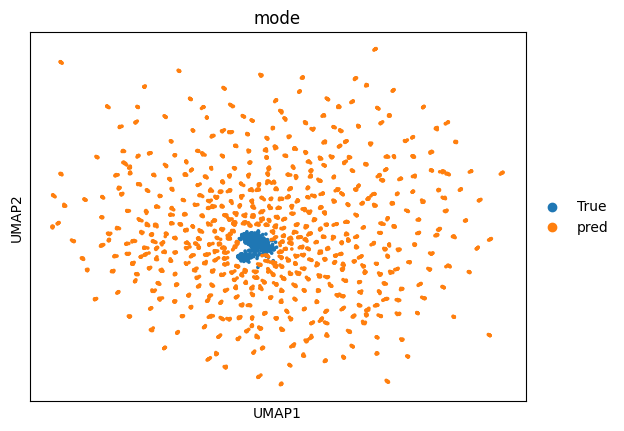

In [121]:
sc.pl.umap(adata_joint, color="mode")

In [122]:
sc.pp.pca(adata_tmp)
sc.pp.neighbors(adata_tmp)
sc.tl.umap(adata_tmp)

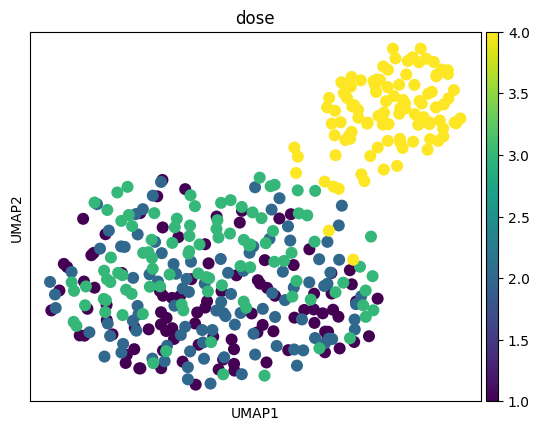

In [123]:
sc.pl.umap(adata_tmp, color="dose")

In [124]:
sc.pp.subsample(adata_pred, fraction=0.2)

In [125]:
adata_joint = anndata.concat((adata_tmp, adata_pred))


In [126]:
sc.pp.pca(adata_joint)
sc.pp.neighbors(adata_joint)
sc.tl.umap(adata_joint)


/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


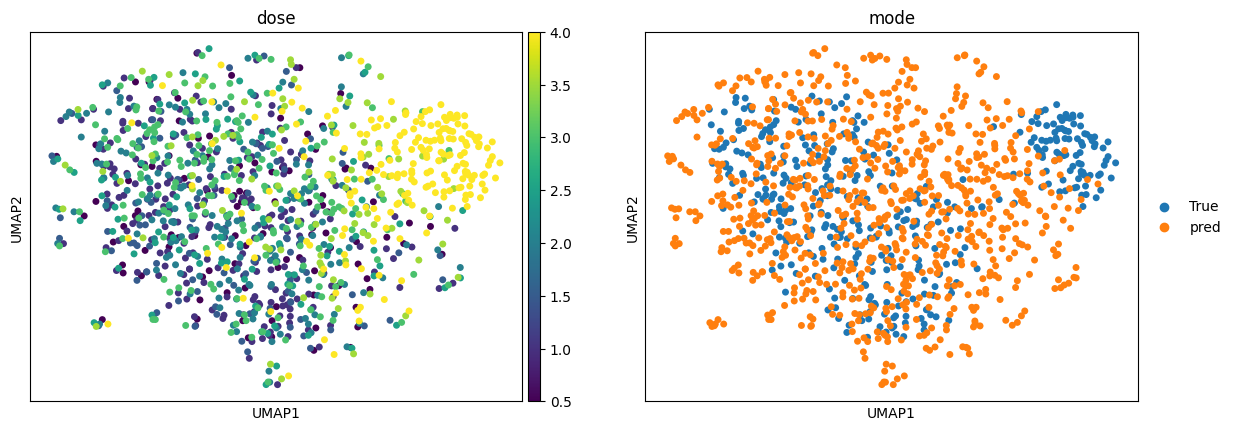

In [127]:
sc.pl.umap(adata_joint, color=["dose", "mode"])